In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from unicodedata import normalize
import tensorflow_text as tf_text
from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,   as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
# Process the data file
def process_pairs(line):
    line = tf.strings.lower(line)
    line = tf_text.normalize_utf8(line, 'NFKD')
    line = tf.strings.regex_replace(line, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), "")
    return line

In [ ]:
dataset_train = train_dataset.map(lambda x, y: (process_pairs(x)))
dataset_test = test_dataset.map(lambda x, y: (process_pairs(x)))

In [ ]:
for x in dataset_train:
   print(x)
   break

tf.Tensor(b'this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it', shape=(), dtype=string)


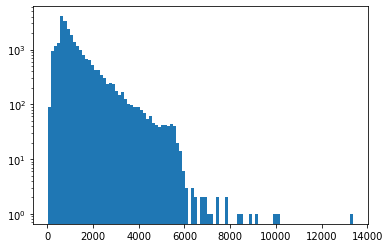

In [ ]:
plt.hist([len(s.numpy()) for s in dataset_train],log=True, bins=100)
plt.show()

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

In [ ]:
custom_standardization('I have watched this [mask] and it was good')

<tf.Tensor: shape=(), dtype=string, numpy=b'i have watched this [mask] and it was good'>

In [ ]:
max_length_word = 250
vocab_size = 30000

lang_tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_mode="int", 
                                                   output_sequence_length=max_length_word, standardize=custom_standardization)
lang_tokenizer.adapt(dataset_train)
vocab = lang_tokenizer.get_vocabulary()

In [ ]:
vocab = vocab[2 : vocab_size - 1] + ["[mask]"]
lang_tokenizer.set_vocabulary(vocab)

train_padded = dataset_train.map(lang_tokenizer)
testing_padded = dataset_test.map(lang_tokenizer)

In [ ]:
id2token = dict(enumerate(lang_tokenizer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

In [ ]:
mask_index = token2id["[mask]"]
mask_index

29999

In [ ]:
# Mask the words in data
def masking_word(train_padded):

    inp_mask = tf.experimental.numpy.random.randn(max_length_word) < 0.15
    mask = inp_mask & (np.random.rand(max_length_word) < 0.15)#    mask = np.random.randn(train_padded.shape[0]) < 1
    y_l = tf.where(train_padded > 1,tf.cast(mask, tf.int64), train_padded)
    y_train = train_padded-y_l*train_padded+y_l*mask_index
    return y_train
   

In [ ]:
y_train = train_padded.map(lambda x: (masking_word(x)))

In [ ]:
y_test = testing_padded.map(lambda x: (masking_word(x)))

In [ ]:
def data_to_numpy(data, label):
    sentences = []
    labels = []
    
    for sentence, y_label in zip(data, label):

        sentences.append(sentence.numpy())
        labels.append(y_label.numpy())

    labels_np = np.array(labels)
    sentences = np.array(sentences)
    return sentences, labels_np
training_sentences, train_mask = data_to_numpy(train_padded, y_train)
testing_sentences, testing_mask = data_to_numpy(testing_padded, y_test)

In [ ]:
testing_sentences, val_sentences, testing_mask, val_mask = train_test_split(testing_sentences, testing_mask, test_size=5000, random_state=42)
len(testing_sentences), len(val_sentences)

(20000, 5000)

In [ ]:
BUFFER_SIZE = len(training_sentences)
BATCH_SIZE = 16
input_vocab_size = vocab_size

dataset = tf.data.Dataset.from_tensor_slices((training_sentences, train_mask)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
BUFFER_SIZE_TEST = len(testing_sentences)
dataset_test = tf.data.Dataset.from_tensor_slices((testing_sentences, testing_mask)).shuffle(BUFFER_SIZE_TEST)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
BUFFER_SIZE_VAL = len(val_sentences)
dataset_val = tf.data.Dataset.from_tensor_slices((val_sentences, val_mask)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.wq = tf.keras.layers.Dense(self.head_dim)
        self.wk = tf.keras.layers.Dense(self.head_dim)
        self.wv = tf.keras.layers.Dense(self.head_dim)
        self.dense = tf.keras.layers.Dense(self.embed_size)


    def call(self, v, k, q, mask):
        # Get number of training examples
        batch_size = q.shape[0]

        seq_len_v, seq_len_k, seq_len_q = v.shape[1], k.shape[1], q.shape[1]


        # Split the embedding into self.heads different pieces
        v = tf.reshape(v,(batch_size,seq_len_v, self.heads, self.head_dim))
        k = tf.reshape(k,(batch_size,seq_len_k, self.heads, self.head_dim))
        q = tf.reshape(q,(batch_size,seq_len_q, self.heads, self.head_dim))


        values = self.wv(v)  # (batch_size, value_len, heads, head_dim)
        keys = self.wk(k)  # (batch_size, key_len, heads, head_dim)
        queries = self.wq(q)  # (batch_size, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example

        attention = tf.einsum("nqhd,nkhd->nhqk", queries, keys)
        # queries shape: (batch_size, seq_len_q, heads, heads_dim),
        # keys shape: (batch_size, seq_len_k, heads, heads_dim)
        # attention: (batch_size, heads, seq_len_q, seq_len_k)

         # scale matmul_qk
        dk = tf.cast(tf.shape(keys)[1], tf.float32)
        scaled_attention_logits = attention / tf.math.sqrt(dk)

        # Mask padded indices so their weights become 0

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        # attention shape: (batch_size, heads, seq_len_q, seq_len_k)



        out = tf.einsum("nhql,nlhd->nqhd", attention_weights, values)
        out = tf.reshape(out, (batch_size, seq_len_q, -1))
        # attention shape: (batch_size, heads, seq_len_q, key_len)
        # values shape: (batch_size, seq_len_v, heads, heads_dim)
        # out after matrix multiply: (batch_size, seq_len_q, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.dense(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out, attention_weights

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, embed_size, heads, forward_expansion, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.self_attens= SelfAttention(embed_size, heads)
    self.ffn = tf.keras.Sequential([
      tf.keras.layers.Dense(forward_expansion, activation='relu'),  # (batch_size, seq_len, forward_expansion)
      tf.keras.layers.Dense(embed_size)  # (batch_size, seq_len, d_model)
       ])

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.self_attens(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

class Encoder(tf.keras.Model):
    def __init__(self, num_layers, embed_size,  heads, forward_expansion, input_vocab_size, max_length, rate=0.1):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.max_length = max_length
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, embed_size)

        self.Layerss =[EncoderLayer(embed_size, heads, forward_expansion, rate)
                       for _ in range(self.num_layers)]
                      

        self.dropout = tf.keras.layers.Dropout(rate)
        self.last_layer = tf.keras.layers.Dense(input_vocab_size, activation = 'softmax')

    def positional_encoding(self):

        pos = np.arange(self.max_length)[:, np.newaxis]
        i = np.arange(self.embed_size)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(self.embed_size))

        angle_rads = pos * angle_rates

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
                                                         
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
        x += self.positional_encoding()[:, :seq_len, :]


        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
           x = self.Layerss[i](x, training, mask)
        x = self.last_layer(x)
        return x  # (batch_size, input_seq_len, vocab_size)

In [ ]:
num_layers = 4
embed_size = 64
heads = 4
forward_expansion  = embed_size*2
input_vocab_size = vocab_size
max_length = 1000 
rate = 0.1
model = Encoder(num_layers,  embed_size, heads, forward_expansion,input_vocab_size, max_length, rate=rate)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
for x, y in dataset:
    mask = create_padding_mask(x)
    outputx = model(x, training=True, mask=mask)
    print(outputx.shape)
    break

(16, 250, 30000)


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [ ]:
@tf.function
def train_step(inp, tar):
    enc_padding_mask = create_padding_mask(inp)

    with tf.GradientTape() as tape:
      logits = model(inp,training = True, mask = enc_padding_mask)
      loss = loss_object(tar, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy.update_state(tar, logits)
    return loss
def val_step(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    logits = model(inp, False, enc_padding_mask)
    loss = loss_object(tar, logits)
    val_accuracy.update_state(tar, logits)
    return loss

In [ ]:
EPOCHS =10
history = {
  "epoch": [],
  "loss": [],
  "Accuracy" :[],
  "Val_loss": [],
  "Val_Accuracy":[]  
}
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  val_loss = 0
#  train_loss.reset_states()
  for (batch, (inp, tar)) in enumerate(dataset):
    batch_loss = train_step(inp, tar)
    total_loss = total_loss+batch_loss
  history['epoch'].append(epoch)
  history['loss'].append(total_loss/(batch+1))
  history['Accuracy'].append(train_accuracy.result())

  # TEST LOOP
  for (batch, (inp, tar)) in enumerate(dataset_val):
    batch_loss = val_step(inp, tar)
    val_loss = val_loss+batch_loss
  history['Val_loss'].append(val_loss/(batch+1))
  history['Val_Accuracy'].append(val_accuracy.result())

  if (epoch+1) % 1 == 0:    
        print(f'Epoch {epoch+1}, Loss: {total_loss/(batch+1):.4f}, Accuracy: {train_accuracy.result():.4f}, Validation Loss: {val_loss/(batch+1):.4f} Validation Accuracy: {val_accuracy.result():.4f}') 
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  train_accuracy.reset_states()
  val_accuracy.reset_states()

Epoch 1, Loss: 29.5543, Accuracy: 0.3197, Validation Loss: 3.4473 Validation Accuracy: 0.5574
Time taken for 1 epoch: 189.62 secs

Epoch 2, Loss: 12.2878, Accuracy: 0.6893, Validation Loss: 1.7344 Validation Accuracy: 0.7726
Time taken for 1 epoch: 190.24 secs

Epoch 3, Loss: 7.1662, Accuracy: 0.8069, Validation Loss: 1.2506 Validation Accuracy: 0.8267
Time taken for 1 epoch: 191.63 secs

Epoch 4, Loss: 5.0411, Accuracy: 0.8548, Validation Loss: 1.0089 Validation Accuracy: 0.8573
Time taken for 1 epoch: 191.55 secs

Epoch 5, Loss: 3.7932, Accuracy: 0.8838, Validation Loss: 0.8646 Validation Accuracy: 0.8770
Time taken for 1 epoch: 191.79 secs

Epoch 6, Loss: 2.9448, Accuracy: 0.9037, Validation Loss: 0.7757 Validation Accuracy: 0.8934
Time taken for 1 epoch: 191.81 secs

Epoch 7, Loss: 2.3334, Accuracy: 0.9182, Validation Loss: 0.7257 Validation Accuracy: 0.9014
Time taken for 1 epoch: 191.64 secs

Epoch 8, Loss: 1.8778, Accuracy: 0.9291, Validation Loss: 0.6938 Validation Accuracy: 0.

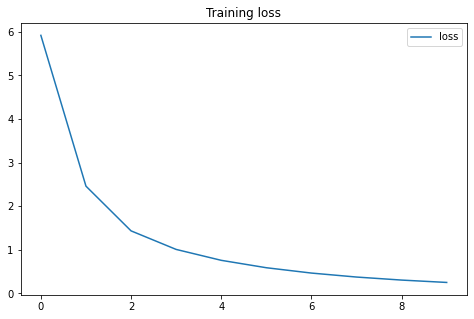

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history["epoch"],history["loss"], label='loss')
plt.title('Training loss')
plt.legend(loc='best')
plt.show()

In [ ]:
def masked_sentence(sentenceX):
    sentence = process_pairs(sentenceX)
    sentence = sentence.numpy()
    print(sentence)
    inputs = lang_tokenizer([sentence])#tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_word, padding='post')
    enc_padding_mask = create_padding_mask(inputs)
    logits = model(inputs, False, enc_padding_mask)
    prob = tf.argmax(logits, axis=-1).numpy()
    print(logits.shape)
    result = ''
    for p in prob[0]:
      if p==0:
        break
      result += id2token[p] + ' ' 
    print(result)


In [ ]:
masked_sentence(u'I have watched this [mask] and he was [mask]')

b'i have watched this [mask] and he was [mask]'
i have watched this astronaut and he was monitors 


In [ ]:
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:

@tf.function
def test_step(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    logits = model(inp, False, enc_padding_mask)
    loss = loss_object(tar, logits)
    test_accuracy.update_state(tar, logits)
    return loss

In [ ]:
start = time.time()
test_loss = 0
for (batch, (inp, tar)) in enumerate(dataset_test):
   batch_loss = test_step(inp, tar)
   test_loss = test_loss+batch_loss
print('Accuracy of model on Test : ', test_accuracy.result().numpy())
print(f'Loss of model on Test : {test_loss.numpy()/(batch+1):.4f}')
print(f'Time taken for epoch: {time.time() - start:.2f} secs\n')
test_accuracy.reset_states()

Accuracy of model on Test :  0.925187
Loss of model on Test : 0.6904
Time taken for 1 epoch: 89.39 secs

